In [22]:
from transformer import Transformer
import pandas as pd
import numpy as np
import tqdm
import re
import torch 
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms.input import AffineInputTransform
import matplotlib.pyplot as plt

<h2>Loading Split Data</h2>

In [2]:
####Training Set #####
# Load the CSV file
path = '/Users/oshapoval/workspace/2024_IFE-superfacility/experimental_data/'
training_set_df = pd.read_csv(path + 'training_set_1.csv')
test_set_df = pd.read_csv(path + '/test_set_1.csv')

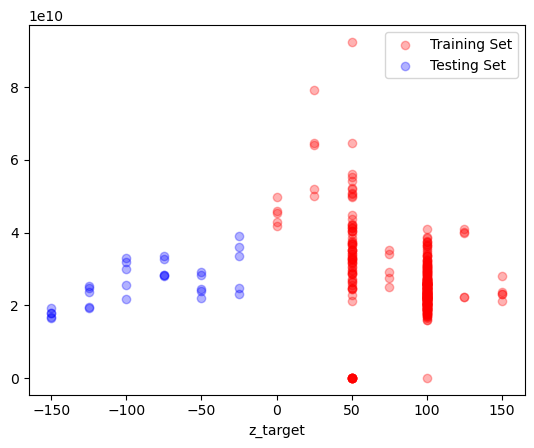

In [3]:
plt.figure()

plt.scatter(training_set_df['z_target (m)'].values,
           training_set_df['n_protons (1/sr)'].values, c='r', alpha=0.3, label='Training Set')
plt.scatter(  test_set_df['z_target (m)'].values,
           test_set_df['n_protons (1/sr)'].values, c='b', alpha=0.3, label='Testing Set')
plt.xlabel('z_target')
plt.legend()

# Visualizing Split Datasets

<Figure size 640x480 with 0 Axes>

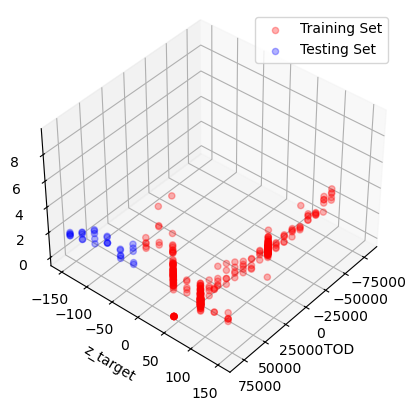

In [4]:
plt.clf()
ax = plt.figure().add_subplot(projection='3d')

ax.scatter( training_set_df['TOD (s^3)'], training_set_df['z_target (m)'],
           training_set_df['n_protons (1/sr)'], c='r', alpha=0.3, label='Training Set')
ax.scatter( test_set_df['TOD (s^3)'], test_set_df['z_target (m)'],
           test_set_df['n_protons (1/sr)'], c='b', alpha=0.3, label='Testing Set')
ax.view_init(elev=40., azim=40, roll=0)
plt.xlabel('TOD')
plt.ylabel('z_target')
plt.legend()

<h2>Normalizing Data</h2>

In [5]:
# Define the input and output normalizations, based on the training set
X = torch.tensor(training_set_df[['z_target (m)', 'TOD (s^3)']].values, dtype=torch.float64)
input_transform = AffineInputTransform(2, coefficient=X.std(axis=0), offset=X.mean(axis=0))
y = torch.tensor(training_set_df['n_protons (1/sr)'].values, dtype=torch.float64).reshape(-1,1)
output_transform = AffineInputTransform( 1, coefficient=y.std(axis=0), offset=y.mean(axis=0))

In [6]:
# Apply normalization to the training and test sets
norm_training_set_df = training_set_df.copy()
norm_training_set_df[['z_target (m)', 'TOD (s^3)']] = input_transform( torch.tensor( training_set_df[['z_target (m)', 'TOD (s^3)']].values ) )
norm_training_set_df[['n_protons (1/sr)']] = output_transform( torch.tensor( training_set_df[['n_protons (1/sr)']].values.reshape(-1,1) ) )

norm_test_set_df = test_set_df.copy()
norm_test_set_df[['z_target (m)', 'TOD (s^3)']] = input_transform( torch.tensor( test_set_df[['z_target (m)', 'TOD (s^3)']].values ) )
norm_test_set_df[['n_protons (1/sr)']] = output_transform( torch.tensor( test_set_df[['n_protons (1/sr)']].values.reshape(-1,1) ) )

<h2>Visualizing Normalized Data</h2>

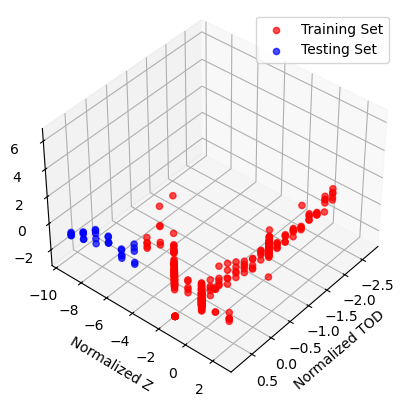

In [7]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter( norm_training_set_df['TOD (s^3)'], norm_training_set_df['z_target (m)'],
           norm_training_set_df['n_protons (1/sr)'], c='r', alpha=0.7, label='Training Set')
ax.scatter( norm_test_set_df['TOD (s^3)'], norm_test_set_df['z_target (m)'],
           norm_test_set_df['n_protons (1/sr)'], c='b', alpha=0.7, label='Testing Set')
ax.view_init(elev=40., azim=40, roll=0)
# Set labels and title
ax.set_xlabel('Normalized TOD')
ax.set_ylabel('Normalized Z')
ax.set_zlabel('Normalized Protons')

# Add legend
ax.legend()
# Show plot
plt.show()

<h1> Defining the Guassain Process & Training </h1>

In [8]:
# Extract the normalized training and test sets
norm_z_train_set = torch.tensor(norm_training_set_df['z_target (m)'].values.reshape(-1,1), dtype=torch.float64)
norm_TOD_train_set = torch.tensor(norm_training_set_df['TOD (s^3)'].values.reshape(-1,1), dtype=torch.float64)
norm_protons_train_set = torch.tensor(norm_training_set_df['n_protons (1/sr)'].values.reshape(-1,1), dtype=torch.float64)
norm_z_test_set = torch.tensor(norm_test_set_df['z_target (m)'].values.reshape(-1,1), dtype=torch.float64)
norm_TOD_test_set = torch.tensor(norm_test_set_df['TOD (s^3)'].values.reshape(-1,1), dtype=torch.float64)
norm_protons_test_set = torch.tensor(norm_test_set_df['n_protons (1/sr)'].values.reshape(-1,1), dtype=torch.float64)


train_x = torch.cat([norm_z_train_set, norm_TOD_train_set], dim=1).detach()
train_y = norm_protons_train_set

test_x = torch.cat([norm_z_test_set, norm_TOD_test_set], dim=1).detach()
test_y = norm_protons_test_set

In [9]:
gp_model = SingleTaskGP(train_x, train_y)
# train model hyperparameters minimizing negative-Log-Marginal-Likelihood
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_mll(mll)

/opt/anaconda3/envs/warpx-cpu-mpich-dev/lib/python3.12/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

<h1> Evaluating The Model </h1>

In [10]:
def eval_mode(model, x_data, y_data):
    """
    Perform predictions using the provided model and likelihood on the given input data.

    Parameters:
    - model: The trained model.
    - likelihood: The likelihood function associated with the model.
    - x_data: The input data for which predictions are to be made.

    Returns:
    - mean_prediction: The mean predictions from the model.
    - lower_bound: The lower bound of the confidence interval.
    - upper_bound: The upper bound of the confidence interval.
    """
    inputs = torch.cat([x_data, y_data], dim=1)
    #model.eval()
    model.likelihood.eval()

    with torch.no_grad():
        predictions = model.likelihood(model(inputs))
        mean_prediction = predictions.mean  # Mean prediction
        lower_bound, upper_bound = predictions.confidence_region()  # Confidence interval

    return mean_prediction, lower_bound, upper_bound

In [11]:
test_mean_prediction, test_lower_set, test_upper_set = eval_mode(gp_model, norm_z_test_set, norm_TOD_test_set)

In [12]:
train_mean_prediction, train_lower_set, train_upper_set = eval_mode(gp_model, norm_z_train_set, norm_TOD_train_set)

/opt/anaconda3/envs/warpx-cpu-mpich-dev/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


<h1> Visualization </h1>

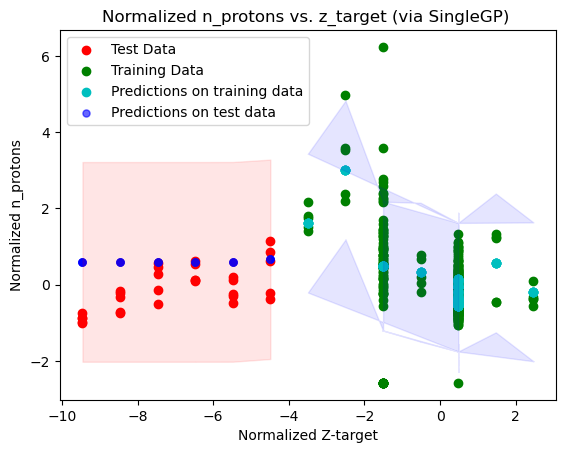

In [16]:
plt.figure()

show_confidence_interval = 'True'

# Scatter plot of the actual test data
plt.scatter(norm_z_test_set.numpy(), norm_protons_test_set.numpy(), c='r', label='Test Data')
plt.scatter(norm_z_train_set.numpy(), norm_protons_train_set.numpy(), c='g', label='Training Data')

plt.scatter(norm_z_train_set.numpy(), train_mean_prediction.numpy(), c='c', label='Predictions on training data')
plt.scatter(norm_z_test_set.numpy(), test_mean_prediction.numpy(), c='b', label='Predictions on test data', alpha=0.6, s=25.89)
#plt.plot(norm_z_train_set.numpy(), train_mean_prediction.numpy(), c='c')
#plt.plot(norm_z_test_set.numpy(), test_mean_prediction.numpy(), c='b')

plt.xlabel('Normalized Z-target')
plt.ylabel('Normalized n_protons')
plt.title('Normalized n_protons vs. z_target (via SingleGP) ')
plt.legend()

if show_confidence_interval == 'True':
    # Fill between the prediction intervals
    plt.fill_between(norm_z_test_set.squeeze().numpy(), test_lower_set.numpy(), test_upper_set.numpy(), alpha=0.1, color='red', label='Confidence Interval')
    plt.fill_between(norm_z_train_set.squeeze().numpy(), train_lower_set.numpy(), train_upper_set.numpy(), alpha=0.1, color='blue', label='Confidence Interval')

# Save the plot
# plt.savefig("./GP_A.png")
plt.show()